In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import pandas as pd
from torch.distributions.multivariate_normal import MultivariateNormal
import random 
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
# set fata types for default
torch.set_default_dtype(torch.float64)
print(device)

cpu


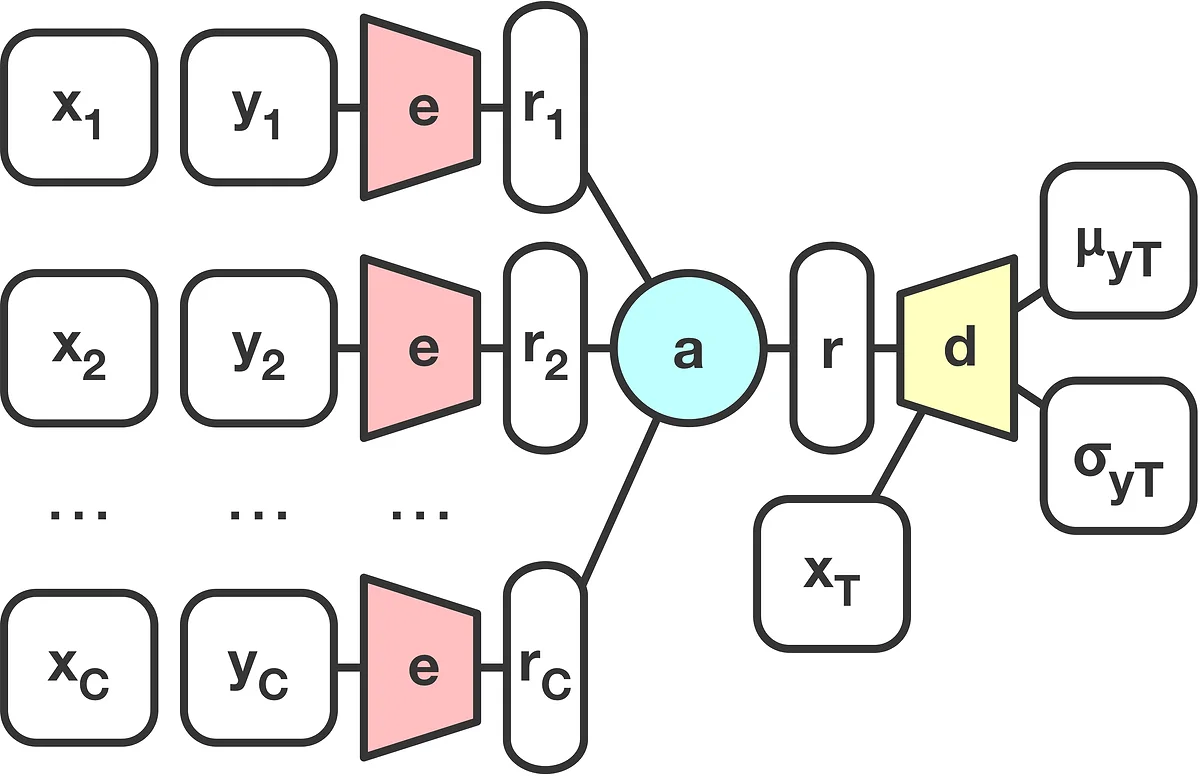

### Data generation and prepration 


In [4]:
# Define hyperparameters
input_dim = 2
hidden_dim = 64
output_dim = 2
num_context = 15
num_target = 5
num_epochs = 500
learning_rate = 1e-3


# Generate real stocks data for training and testing
def generate_real_data(num_context, num_target , temp):
    df = pd.read_csv("AAPL_price.csv")
    df["ind_x"] = df.index.astype("float64")
    df = df[["ind_x" , "Close" ]]
#     duration = num_context+ num_target
    duration = 2
    context_x = torch.unsqueeze(torch.tensor(df.loc[temp*duration:num_context+temp*duration , :]["ind_x"].values) , 1)
    context_y = torch.unsqueeze(torch.tensor(df.loc[temp*duration:num_context+temp*duration , :]["Close"].values) , 1)
    target_x = torch.unsqueeze(torch.tensor(df.loc[num_context+temp*duration:num_target+num_context+temp*duration , :]["ind_x"].values) , 1)
    target_y = torch.unsqueeze(torch.tensor(df.loc[num_context+temp*duration:num_target+num_context+temp*duration , :]["Close"].values) , 1)
    
    return context_x, context_y, target_x, target_y




# # Generate synthesis GP data for training and testing
# def generate_GP_data()

#     return pass 

In [5]:
# enc = CNPEncoder(2,64)
# context = torch.cat([context_x, context_y], dim=-1)
# print(context.shape)
# agg = enc(context)
# print(torch.mean(agg , 0).shape)

### Model structure 

In [6]:
# Define the Encoder network
class CNPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CNPEncoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim )
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        
        return x



# Define the Decoder network
class CNPDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim ):
        super(CNPDecoder, self).__init__()
        self.fc1 = nn.Linear(int(input_dim/2)+hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim )
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the Conditional Neural Process model
class CNP(nn.Module):
    def __init__(self, encoder, decoder):
        super(CNP, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, context_x, context_y, target_x ):
        # Encode the context pairs (context_x, context_y)
        context = torch.cat([context_x, context_y], dim=-1)
        rep = self.encoder(context)
        
        
        #aggregate the representations 
        aggregated = torch.mean(rep , 0)
        
            
        # Repeat the aggregated representation for each target point
        num_targets = target_x.size(0)
        aggregated = aggregated.unsqueeze(0).repeat(num_targets, 1)
        
        # Concatenate the target points with the aggregated representation
        target = torch.cat([target_x, aggregated], dim=-1)
        # i.e return  [10  ,   64+1 ]
        
        # Decode the target points
        target_y = self.decoder(target)
        
        return target_y
#      i.e. [10 , 2 ] 
    
  
        

### Train and Test 

In [12]:
c1 = 0.1
# Define the training procedure
def train(model, optimizer, context_x, context_y, target_x, target_y):
    # model is ready to train
    model.train()
    
    
    optimizer.zero_grad()
    
    # Forward pass
    target_y_pred = model(context_x, context_y, target_x)
    mean_pred = target_y_pred[:,0]
    log_sigma_pred = target_y_pred[:,1]
#     sigma_pred = 0.1 + 0.9 * torch.nn.Softplus(log_sigma_pred)
    sigma_pred = torch.log(1+torch.exp(log_sigma_pred))
    sigma_conv_pred= torch.diag(sigma_pred)
    
    dist = MultivariateNormal(mean_pred , sigma_conv_pred)
    log_p = dist.log_prob(target_y.squeeze(1))
    loss = -log_p.mean()
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item() , mean_pred , sigma_pred

# Define the testing procedure
def test(model, context_x, context_y, target_x):
#     model is ready for test
    model.eval()
    
    with torch.no_grad():
        # Forward pass
        target_y_pred = model(context_x, context_y, target_x)
    
    return target_y_pred


In [13]:

# Create the CNP model and optimizer
encoder = CNPEncoder(input_dim , hidden_dim)
decoder = CNPDecoder(input_dim , hidden_dim, output_dim)
model = CNP(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 0, Loss: 14.6087 , count:1


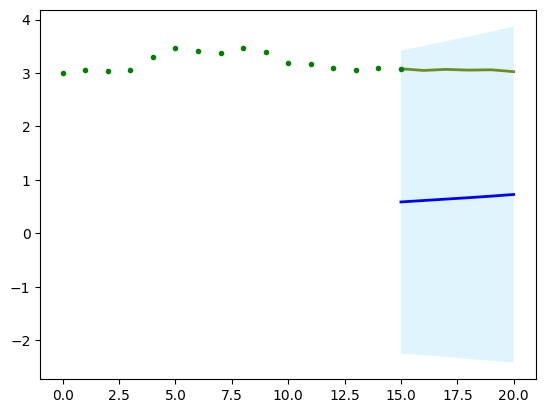

Epoch 10, Loss: 13.7128 , count:11


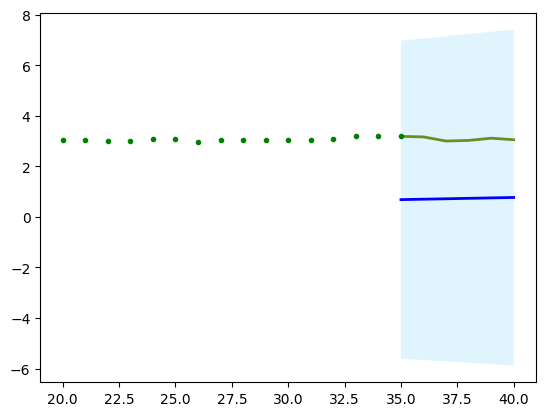

Epoch 20, Loss: 13.8914 , count:21


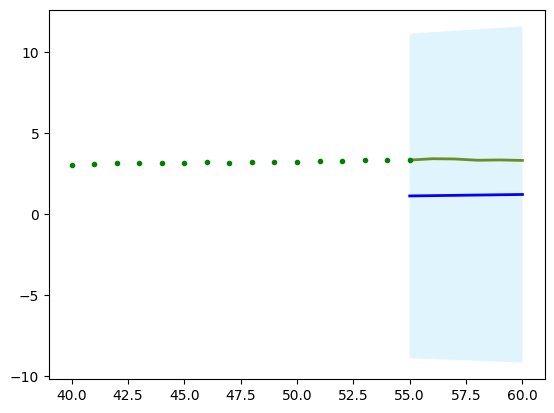

Epoch 30, Loss: 13.9253 , count:31


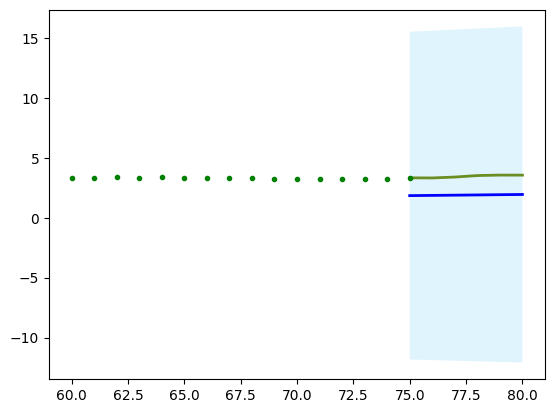

Epoch 40, Loss: 14.2605 , count:41


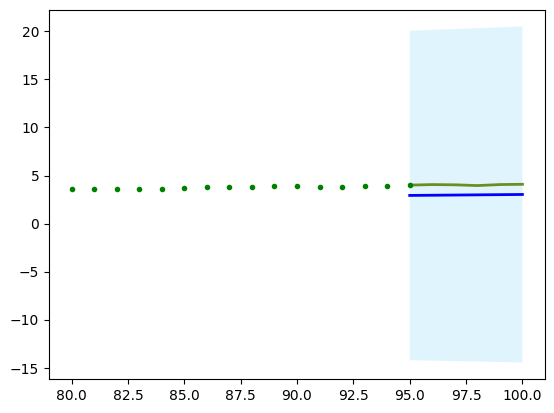

Epoch 50, Loss: 14.5363 , count:51


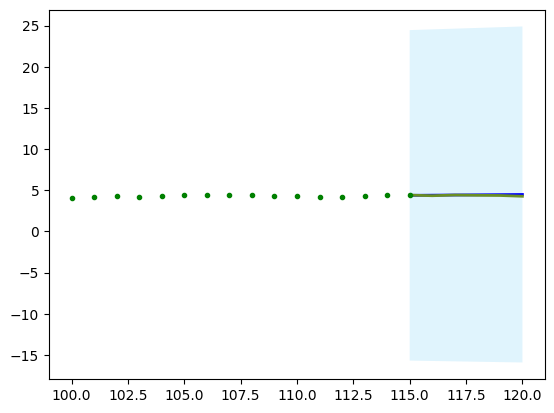

Epoch 60, Loss: 14.9287 , count:61


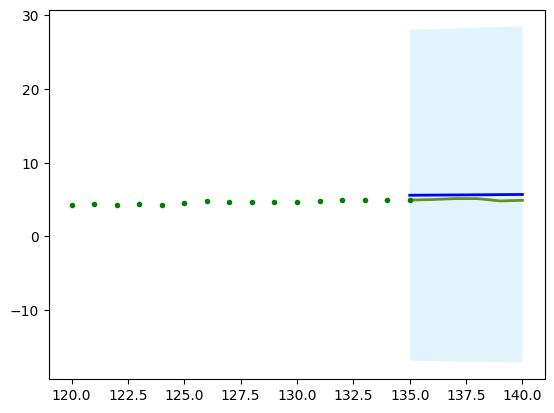

Epoch 70, Loss: 15.4686 , count:71


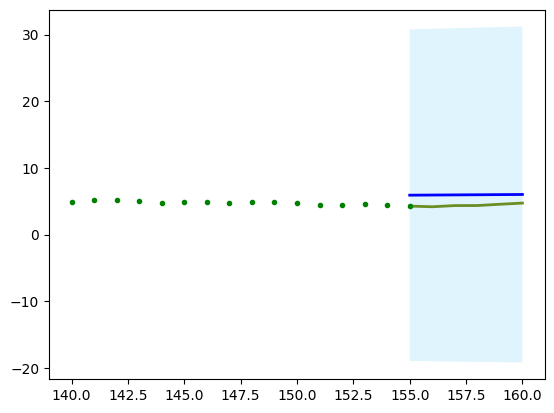

Epoch 80, Loss: 15.5726 , count:81


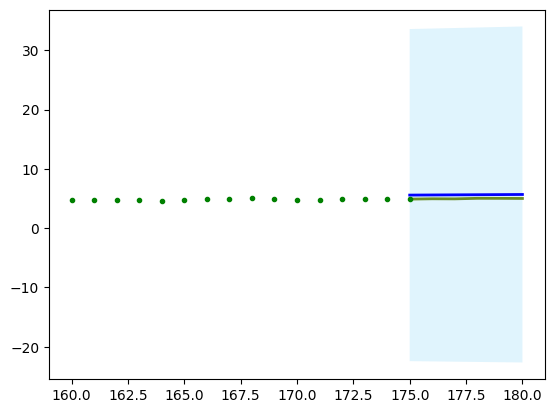

Epoch 90, Loss: 15.8012 , count:91


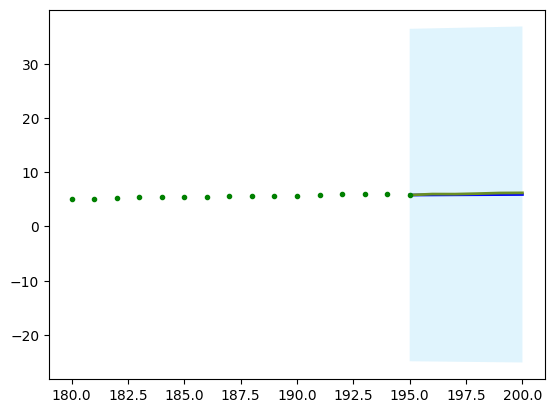

Epoch 100, Loss: 16.0413 , count:101


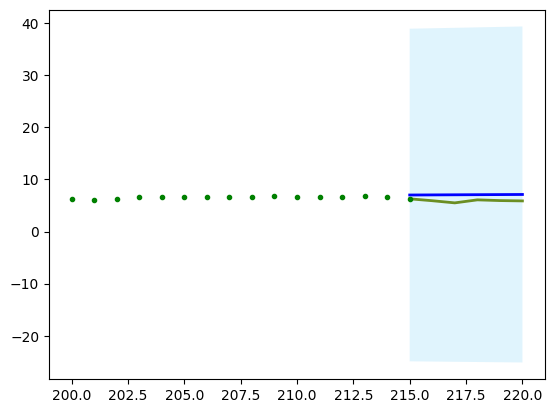

Epoch 110, Loss: 16.0904 , count:111


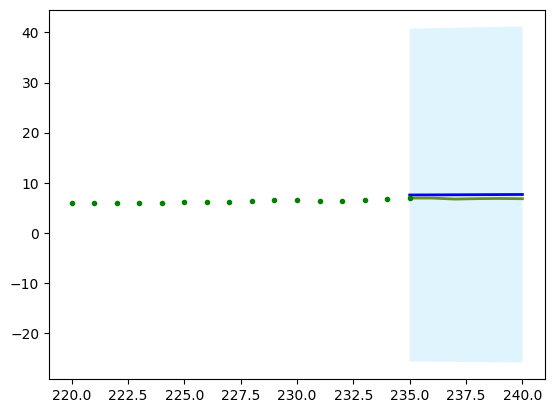

Epoch 120, Loss: 16.3468 , count:121


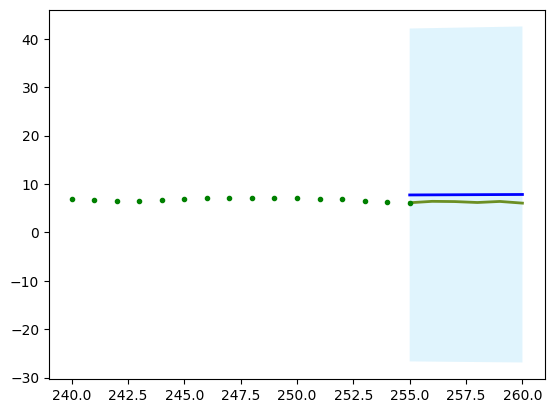

Epoch 130, Loss: 16.7605 , count:131


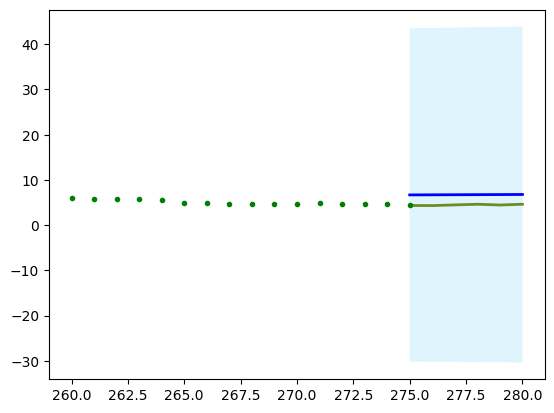

Epoch 140, Loss: 16.6401 , count:141


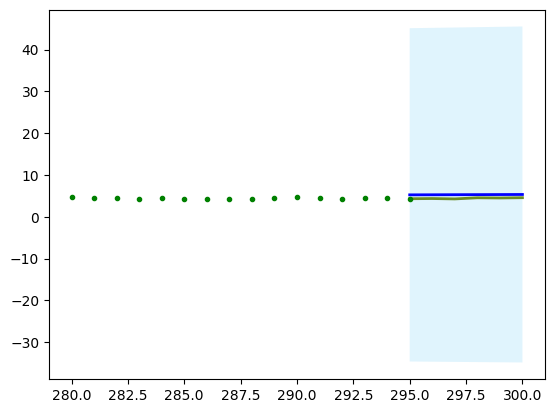

Epoch 150, Loss: 16.5972 , count:151


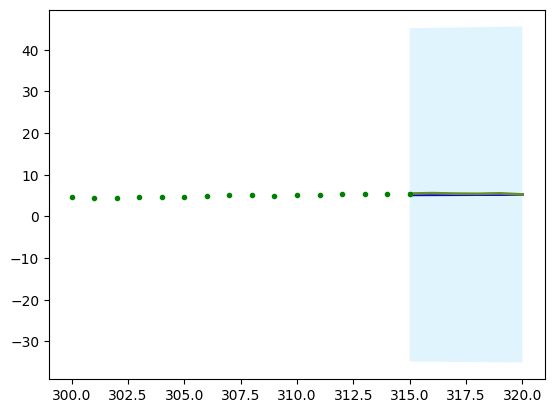

Epoch 160, Loss: 16.4296 , count:161


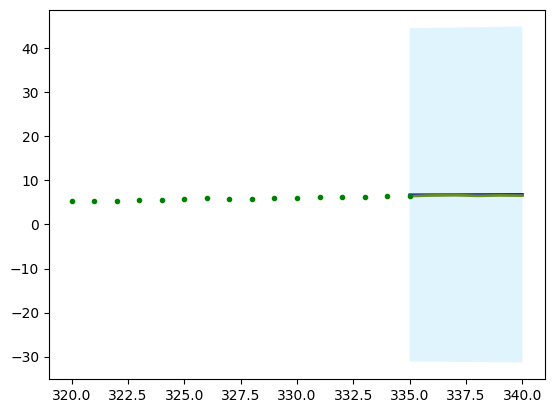

Epoch 170, Loss: 15.9835 , count:171


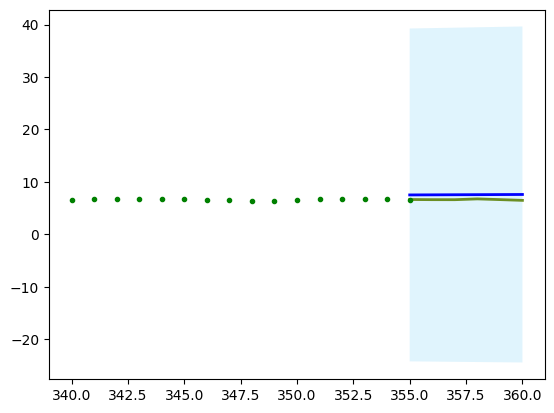

Epoch 180, Loss: 11.2634 , count:181


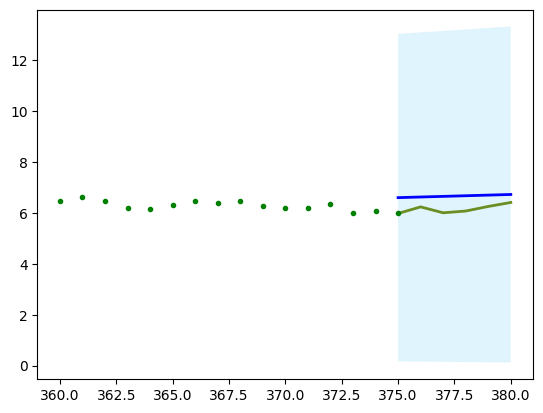

Epoch 190, Loss: 58.4526 , count:191


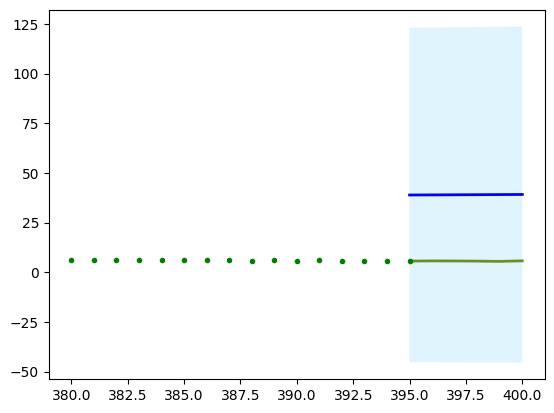

Epoch 200, Loss: 84.9007 , count:201


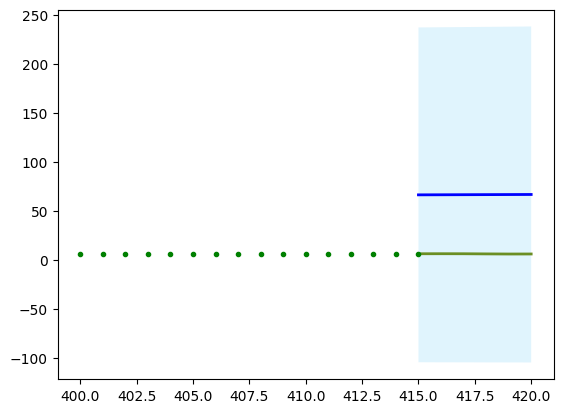

Epoch 210, Loss: 67.9688 , count:211


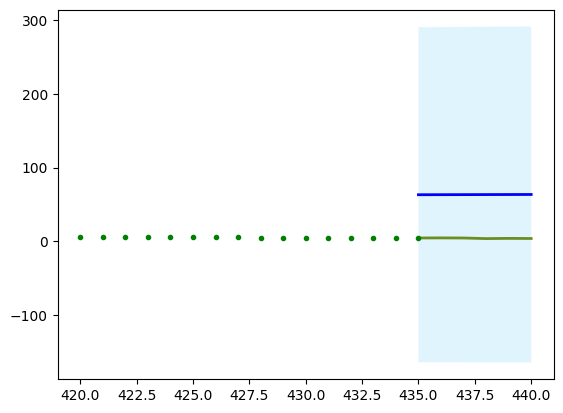

Epoch 220, Loss: 32.2185 , count:221


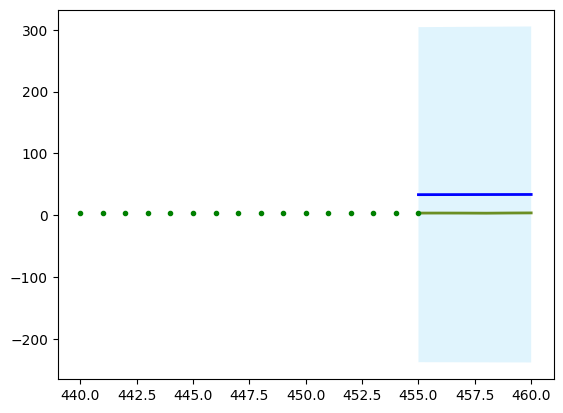

Epoch 230, Loss: 22.8685 , count:231


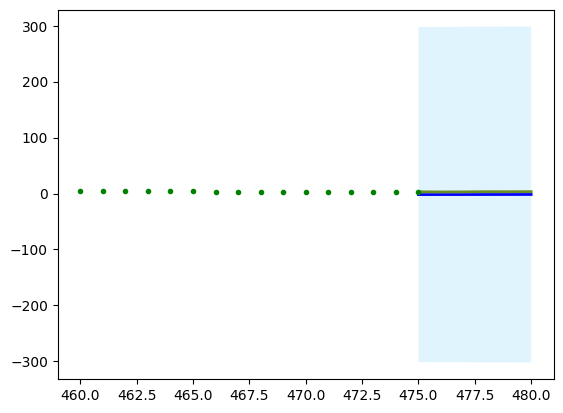

Epoch 240, Loss: 24.3937 , count:241


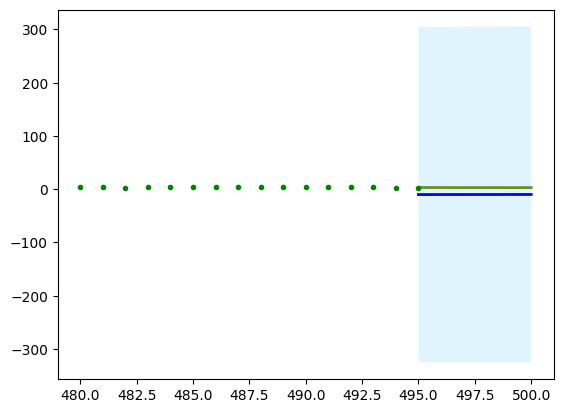

Epoch 250, Loss: 22.9099 , count:251


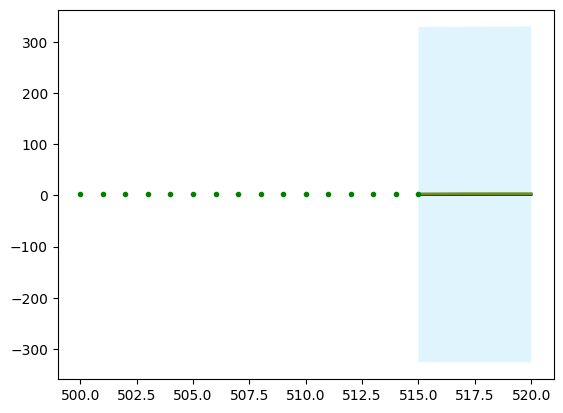

Epoch 260, Loss: 23.1634 , count:261


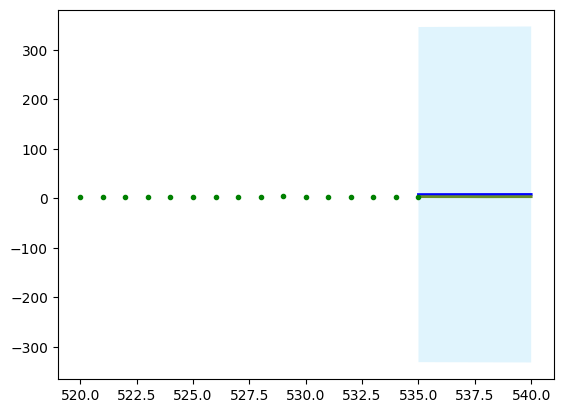

Epoch 270, Loss: 23.1144 , count:271


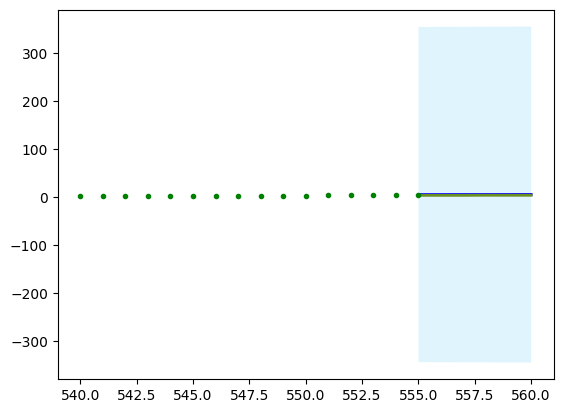

Epoch 280, Loss: 23.2044 , count:281


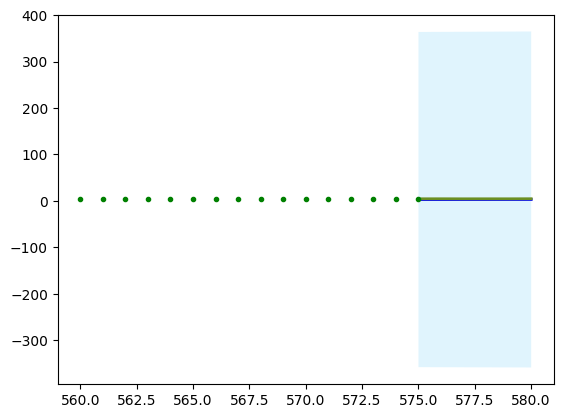

Epoch 290, Loss: 23.2749 , count:291


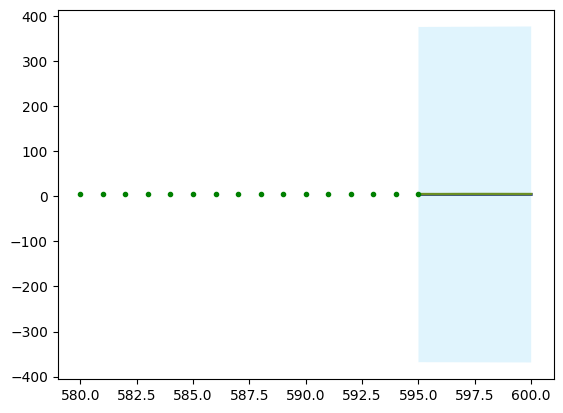

Epoch 300, Loss: 23.3556 , count:301


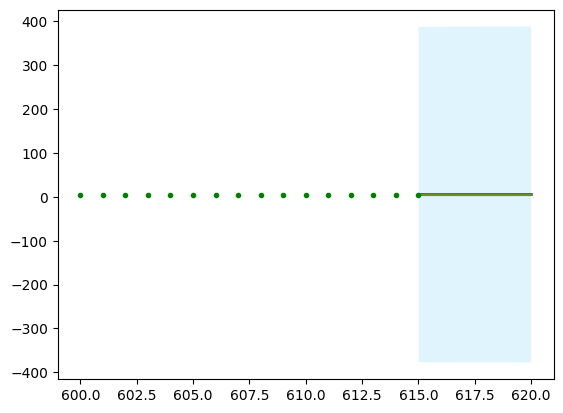

Epoch 310, Loss: 23.4343 , count:311


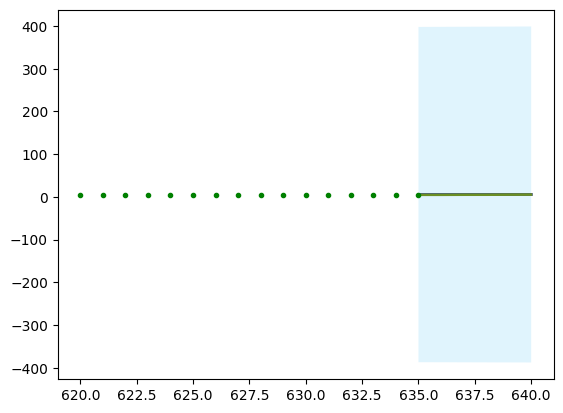

Epoch 320, Loss: 23.5121 , count:321


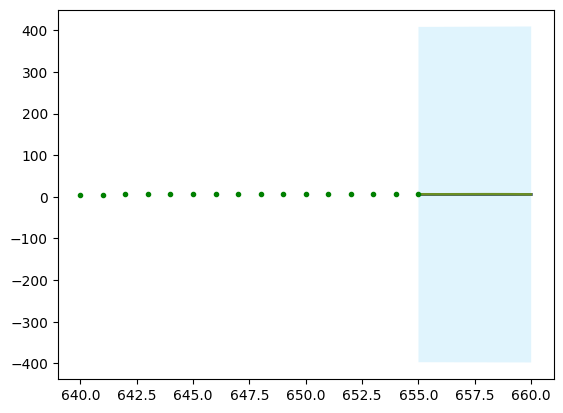

Epoch 330, Loss: 23.5847 , count:331


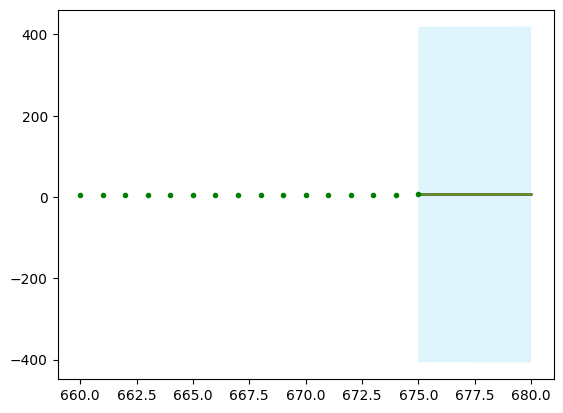

Epoch 340, Loss: 23.6560 , count:341


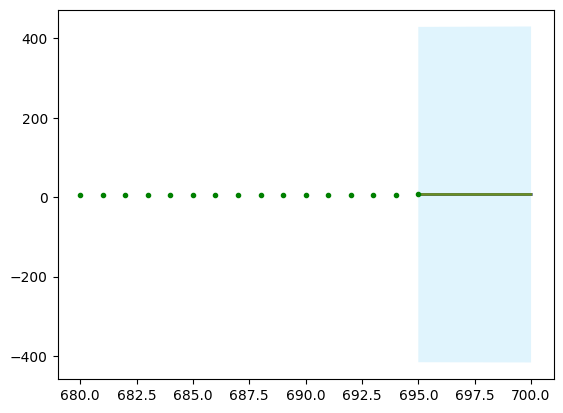

Epoch 350, Loss: 23.7247 , count:351


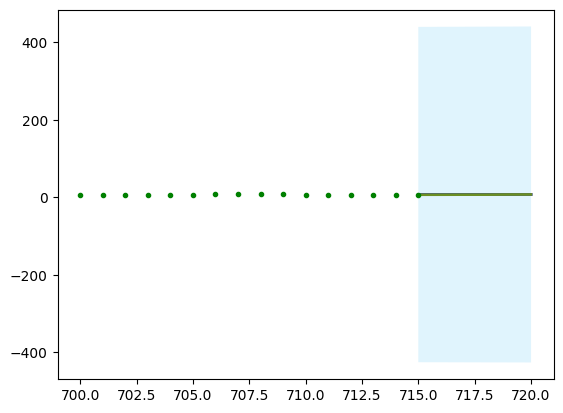

Epoch 360, Loss: 23.7916 , count:361


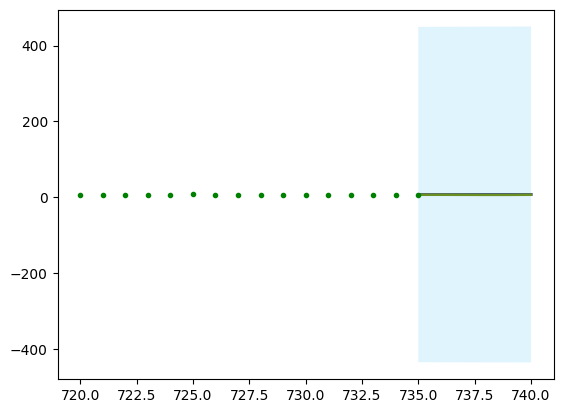

Epoch 370, Loss: 23.8549 , count:371


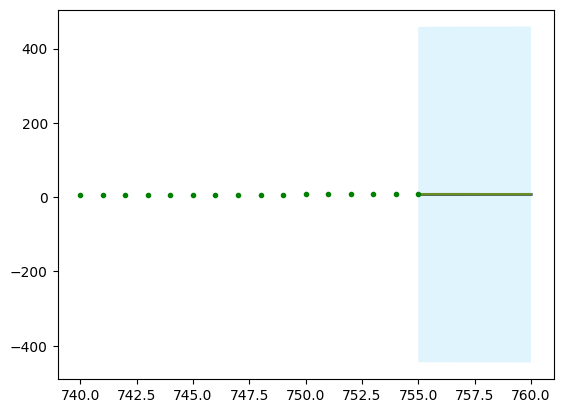

Epoch 380, Loss: 23.9196 , count:381


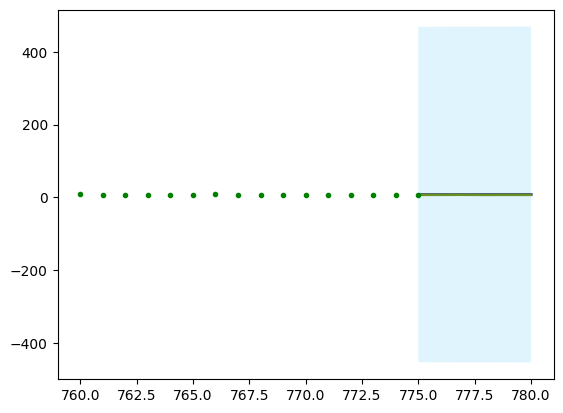

Epoch 390, Loss: 23.9806 , count:391


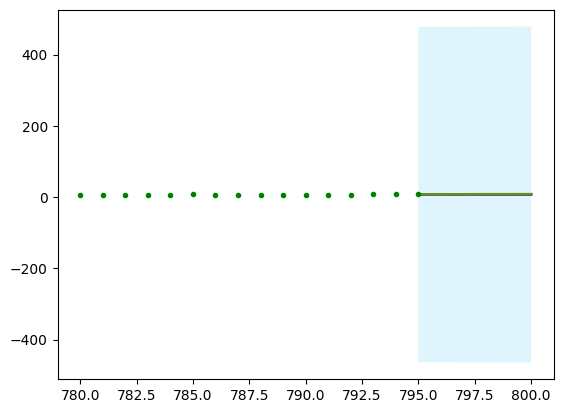

Epoch 400, Loss: 24.0409 , count:401


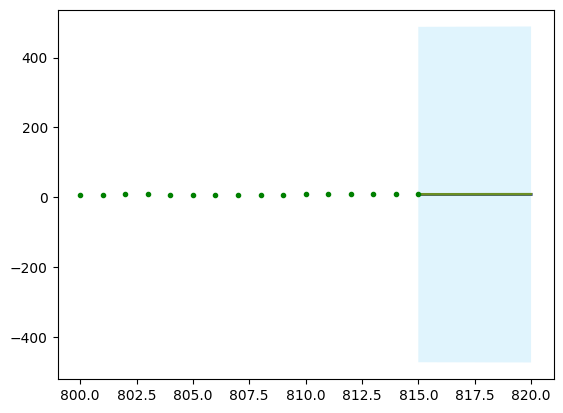

Epoch 410, Loss: 24.0982 , count:411


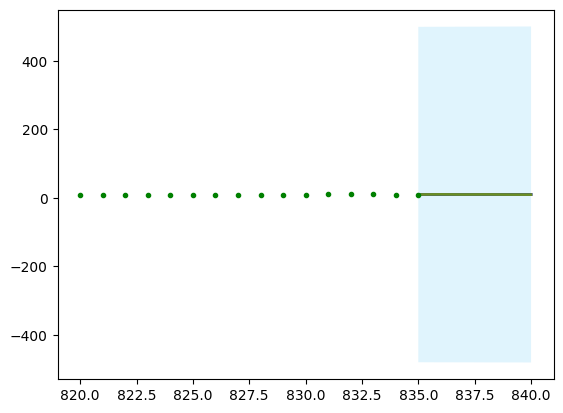

Epoch 420, Loss: 24.1547 , count:421


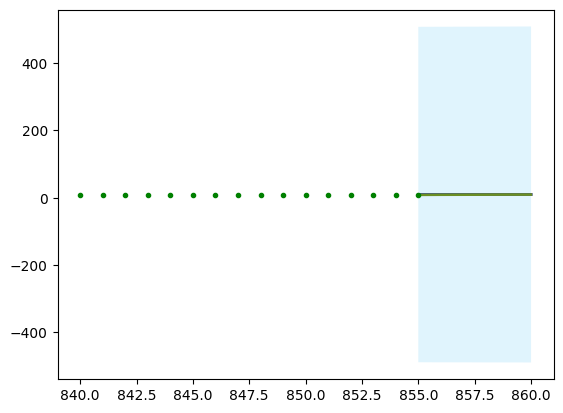

Epoch 430, Loss: 24.2096 , count:431


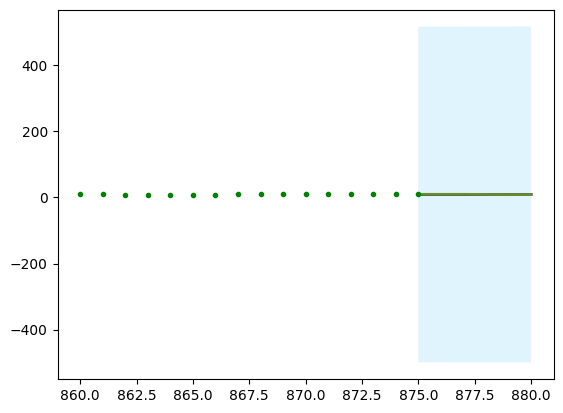

Epoch 440, Loss: 24.2610 , count:441


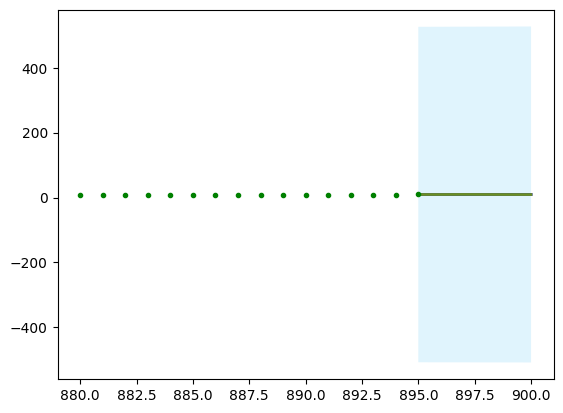

Epoch 450, Loss: 24.3136 , count:451


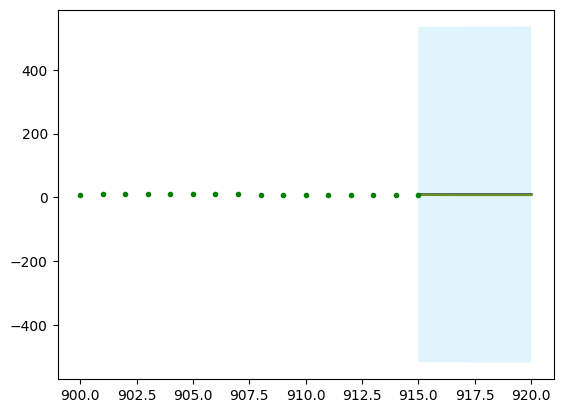

Epoch 460, Loss: 24.3696 , count:461


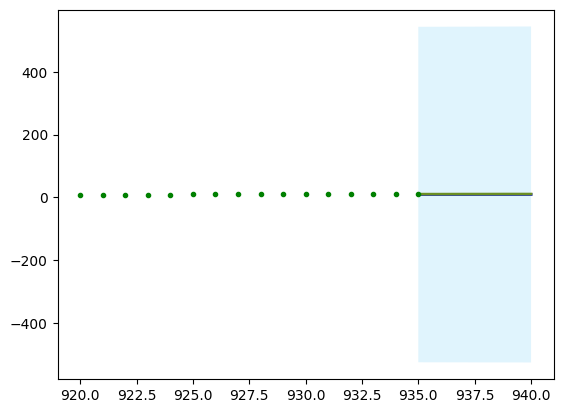

Epoch 470, Loss: 24.4108 , count:471


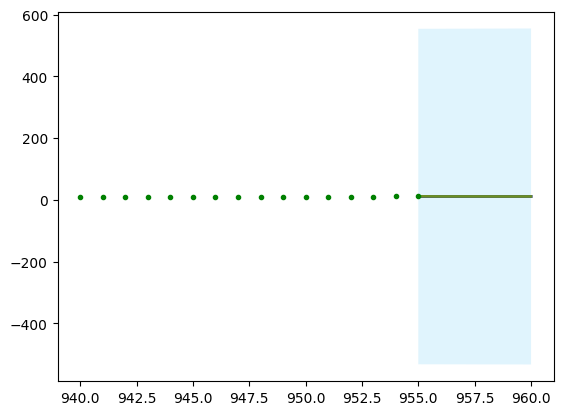

Epoch 480, Loss: 24.4604 , count:481


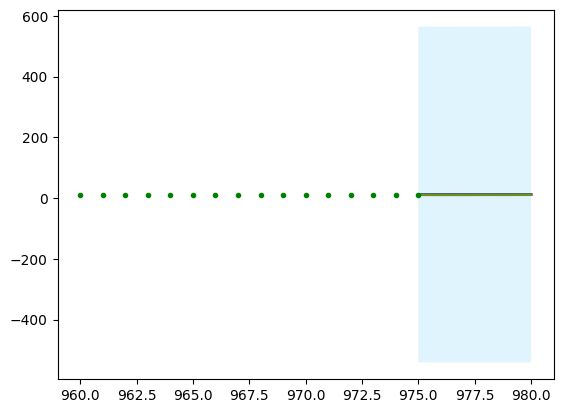

Epoch 490, Loss: 24.5035 , count:491


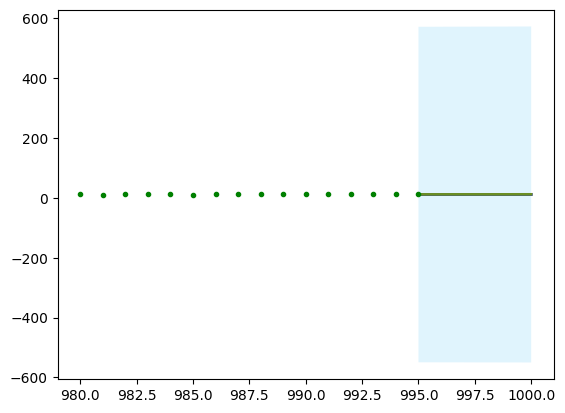

In [48]:
# Train the model
count = 0 
num_epochs = 500
for epoch in range(num_epochs):
    context_x, context_y, target_x, target_y = generate_real_data(num_context, num_target , count)
    count+=1
    loss , mu , sigma = train(model, optimizer, context_x, context_y, target_x, target_y)
    

    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f} , count:{count}")
        
        plt.plot(target_x, mu.detach().numpy(), 'blue', linewidth=2)
        plt.plot(target_x, target_y, 'olivedrab', linewidth=2)
        plt.plot(context_x, context_y, 'go', markersize=3)
        plt.fill_between(
        target_x[:,0],
        mu.detach().numpy() - sigma.detach().numpy(),
        mu.detach().numpy() + sigma.detach().numpy(),
        alpha=0.2,
        facecolor='#65c9f7',
        interpolate=True)
        plt.show()

# # Test the model
# context_x, context_y, target_x, target_y = generate_data(num_context, num_target)
# target_y_pred = test(model, context_x, context_y, target_x)
